In [1]:
pip install transformers datasets rouge-score nltk


In [2]:
!pip install -U fsspec==2023.6.0


In [3]:
from datasets import load_dataset
import nltk
nltk.download("punkt")

dataset = load_dataset("cnn_dailymail", "3.0.0")

# Tokenization helper
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

def preprocess(example):
    inputs = tokenizer.batch_encode_plus(example['article'], max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
    targets = tokenizer.batch_encode_plus(example['highlights'], max_length=128, truncation=True, padding="max_length", return_tensors="pt")
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': targets['input_ids']
    }

# Optional: use a subset to reduce time for testing
small_train = dataset['train'].select(range(500))  # Use more for actual training
small_test = dataset['test'].select(range(100))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [4]:
from transformers import BartForConditionalGeneration, Trainer, TrainingArguments

model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

training_args = TrainingArguments(
    output_dir="./results_bart",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"  # Remove if using wandb
)

from datasets import Dataset
train_dataset = small_train.map(preprocess, batched=True)
test_dataset = small_test.map(preprocess, batched=True)

# Remove text columns
# train_dataset.set_format(type="numpy", columns=['input_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type="numpy", columns=['input_ids', 'attention_mask', 'labels'])

# train_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss
10,4.434300
20,1.398400
30,1.039400
40,0.806600
50,0.734300
60,0.667200
70,0.681800
80,0.678800
90,0.744200
100,0.712200


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=750, training_loss=0.45192068258921303, metrics={'train_runtime': 922.1418, 'train_samples_per_second': 1.627, 'train_steps_per_second': 0.813, 'total_flos': 3250656903168000.0, 'train_loss': 0.45192068258921303, 'epoch': 3.0})

In [6]:
from datasets import load_metric
import numpy as np
import torch

rouge = load_metric("rouge")

def generate_summary(batch):
    inputs = tokenizer(batch["article"], return_tensors="pt", max_length=1024, truncation=True)
    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    batch["generated"] = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return batch

# Apply on test samples
samples = dataset["test"].select(range(100)).map(generate_summary)

# Evaluate
preds = [x["generated"] for x in samples]
refs = [x["highlights"] for x in samples]

results = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
for key in results:
    print(f"{key}: {results[key].mid.fmeasure:.4f}")

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

rouge1: 0.3469
rouge2: 0.1347
rougeL: 0.2473
rougeLsum: 0.3214


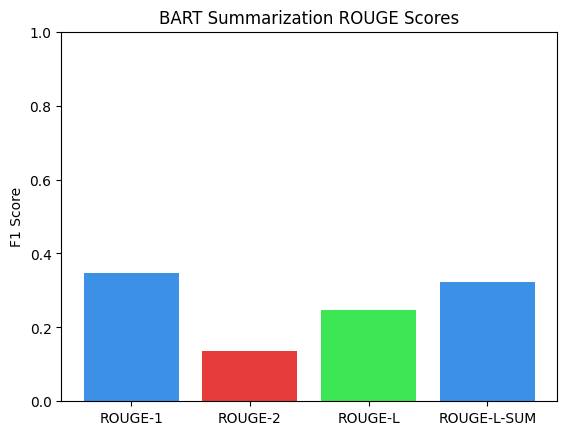

In [8]:
import matplotlib.pyplot as plt

scores = {"ROUGE-1": 0.3469, "ROUGE-2": 0.1347, "ROUGE-L": 0.2473 , "ROUGE-L-SUM": 0.3214}

plt.bar(scores.keys(), scores.values(), color=["#3c91e6", "#e63c3c", "#3ce654"])
plt.title("BART Summarization ROUGE Scores")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()
